In [68]:
import numpy as np
import arepo
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib as mpl

from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm

import re
import astropy.units as u


In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f



In [5]:
sn = read_snap(600, 1, fields=None)

In [39]:
center = np.array([200., 200., 200.])
torque_gas_z = sn.part0.mass * np.cross(sn.part0.pos.value - center, sn.part0.acce)[:,2]

In [12]:
bpath ='/n/home01/abeane/starbar/plots/torques/data/torques_phantom-vacuum-Sg20-Rc3.5-lvl3/'
t = h5.File(bpath + 'torques_phantom-vacuum-Sg20-Rc3.5-lvl3.600.hdf5', mode='r')

In [38]:
torque_gas_bar_z = t['gas_mass'] * np.cross(t['pos_gas'], t['acc_gas'])[:,2]

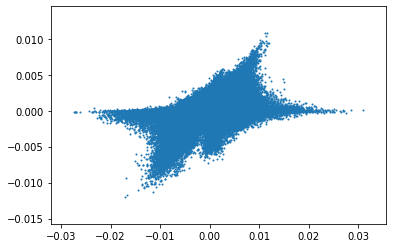

In [40]:

plt.scatter(torque_gas_z, torque_gas_bar_z, s=1)
plt.show()

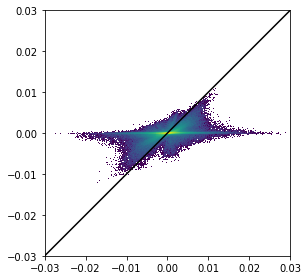

In [42]:
nres = 256

range_xy = [[-0.03, 0.03], [-0.03, 0.03]]

x = torque_gas_z
y = torque_gas_bar_z
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.plot([-0.03, 0.03], [-0.03, 0.03], c='k')
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [93]:
def compute_total_gas_torque(idx, pot_center=True):
    center = np.array([200., 200., 200.])
    sn = read_snap(idx, 1, lvl='lvl3', parttype=[0, 1], fields=['Coordinates', 'Acceleration', 'Masses', 'Potential'])
    if pot_center:
        center = sn.part1.pos.value[np.argmin(sn.part1.pot)]
    
#     print(center)
    
    pos = sn.part0.pos.value - center
    acc = sn.part0.acce
    torque = sn.part0.mass.value * np.cross(pos, acc)[:,2]
    return np.sum(torque)
    

In [94]:
idx_list = np.arange(1200, 1400)
torque_list_old_center = Parallel(n_jobs=32) (delayed(compute_total_gas_torque)(i, pot_center=False) for i in tqdm(idx_list))

A Jupyter Widget

In [95]:
# idx_list = np.arange(1200, 1400)
torque_list = Parallel(n_jobs=32) (delayed(compute_total_gas_torque)(i) for i in tqdm(idx_list))

A Jupyter Widget

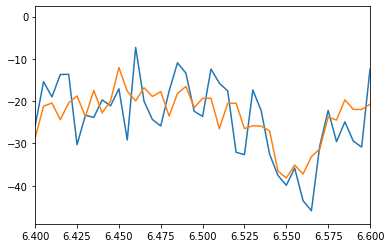

In [97]:
plt.plot(idx_list/200.0, torque_list_old_center)
plt.plot(idx_list/200.0, torque_list)
plt.xlim(6.4, 6.6)
# plt.xlim(3, 4)
plt.show()

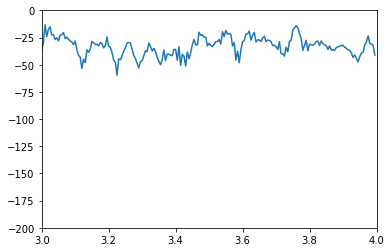

In [91]:
plt.plot(idx_list/200.0, torque_list)
plt.xlim(3, 4)
plt.ylim(-200, 0)
plt.show()

In [62]:
def extract_t_A2A0(fourier, idx):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        A2r = fourier[key]['A2r'][idx]
        A2i = fourier[key]['A2i'][idx]
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
        A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_max_A2A0(fourier, debug=False):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = np.array(fourier[key]['A0'])
        A2r = np.array(fourier[key]['A2r'])
        A2i = np.array(fourier[key]['A2i'])
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
#         A2A0 = A2/A0
        A2A0list.append(np.max(A2/A0))
        if debug:
            print(tlist[i], fourier[key]['Rlist'][np.argmax(A2/A0)], np.max(A2/A0))
#         A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_AmA0(fourier, idx, m):

    i = 0

    tlist = np.array(fourier['time'])
    AmA0list = []
#     print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        Amr = fourier[key]['A'+str(m)+'r'][idx]
        Ami = fourier[key]['A'+str(m)+'i'][idx]
    
        Am = np.sqrt(Amr*Amr + Ami*Ami)
        AmA0list.append(Am/A0)
        i += 1
    
    return np.array(tlist), np.array(AmA0list)

In [63]:
def get_bar_angle(phi, firstkey):
    out = np.zeros(len(phi))

    # set the first bar angle
    first_bar_angle = phi[firstkey]/2.0
    out[firstkey] = first_bar_angle
    
    # set all subsequent angles
    for i in np.arange(firstkey+1, len(out)):
        dphi = phi[i] - phi[i-1]
        if dphi < -np.pi:
            dphi += 2.*np.pi
        out[i] = out[i-1] + dphi/2.0

    # set all previous angles to be the bar angle
    for i in np.arange(0, firstkey):
        out[i] = first_bar_angle

    return out

def get_sorted_keys(dat):
    keys = list(dat.keys())
    # only keep keys that are snapshot keys
    keys = [k for k in keys if 'snapshot' in k]

    # extract and sort indices
    indices = [int(re.findall(r'\d?\d?\d\d\d', k)[0]) for k in keys]
    sorted_arg = np.argsort(indices)
    keys_sorted = [keys[i] for i in sorted_arg]

    return keys_sorted

def get_A2_angle(dat, keys, Rbin, cum=False):
    if cum:
        rk = 'A2r_c'
        ri = 'A2i_c'
    else:
        rk = 'A2r'
        ri = 'A2i'
    
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])
    A2r = np.array([np.array(dat[k][rk]) for k in keys])
    A2i = np.array([np.array(dat[k][ri]) for k in keys])
    phi = np.arctan2(A2i, A2r)
    phi = phi[:,Rbin]
    R_at_Rbin = Rlist[:,Rbin]
    
    time = np.array(dat['time'])

    return time, R_at_Rbin, phi

def get_bar_length(dat, keys, Rmin=2, Rmax=10, ratio_cut = 2):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])

    A0 = np.array([np.array(dat[k]['A0']) for k in keys])
    A1r = np.array([np.array(dat[k]['A1r']) for k in keys])
    A1i = np.array([np.array(dat[k]['A1i']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    A3r = np.array([np.array(dat[k]['A3r']) for k in keys])
    A3i = np.array([np.array(dat[k]['A3i']) for k in keys])
    A4r = np.array([np.array(dat[k]['A4r']) for k in keys])
    A4i = np.array([np.array(dat[k]['A4i']) for k in keys])
    A5r = np.array([np.array(dat[k]['A5r']) for k in keys])
    A5i = np.array([np.array(dat[k]['A5i']) for k in keys])
    A6r = np.array([np.array(dat[k]['A6r']) for k in keys])
    A6i = np.array([np.array(dat[k]['A6i']) for k in keys])
    
    I0 = A0/2.
    I1 = np.sqrt(A1r*A1r + A1i*A1i)
    I2 = np.sqrt(A2r*A2r + A2i*A2i)
    I3 = np.sqrt(A3r*A3r + A3i*A3i)
    I4 = np.sqrt(A4r*A4r + A4i*A4i)
    I5 = np.sqrt(A5r*A5r + A5i*A5i)
    I6 = np.sqrt(A6r*A6r + A6i*A6i)
    
    Ib = I0 + I2 + I4 + I6
    Iib = I0 - I2 + I4 - I6
    
    IbIib = Ib/Iib
    
    Rbar_list = []
    for i,k in enumerate(keys):
        R = Rlist[i,:]
        ratio = IbIib[i,:]
        
        Rkey = np.logical_and(R > Rmin, R< Rmax)
        ratio = ratio[Rkey]
        R = R[Rkey]
        j = 0
        try:
            while ratio[j] > ratio_cut:
                j += 1
            Rbar = R[j-1] + (ratio_cut - ratio[j-1]) * (R[j]-R[j-1])/(ratio[j]-ratio[j-1])
        except:
            Rbar = np.nan
        Rbar_list.append(Rbar)

    time = np.array(dat['time'])    
    
    return time, np.array(Rbar_list)

def evaluate_polynomial(pfit, n, time, bar_angle_firstkey, firstkey):
    pfit_n = pfit[n]
    poly_bar_angle = np.zeros(len(time))
    poly_pattern_speed = np.zeros(len(time))

    for i in range(n+1):
        ba = pfit_n[i] * time ** (n-i)
        poly_bar_angle[firstkey:] += ba[firstkey:]
        ps = (n-i) * pfit_n[i] * time**(n-1-i)
        poly_pattern_speed[firstkey:] += ps[firstkey:]

    poly_bar_angle[:firstkey] += bar_angle_firstkey

    poly_pattern_speed = poly_pattern_speed / u.Myr
    poly_pattern_speed = poly_pattern_speed.to_value(u.km/u.s/u.kpc)

    return poly_bar_angle, poly_pattern_speed

def main_bar_angle(dat, Rbin = 3, firstkey = 150, nmax = 10, cum=False):
    # try loading snapshot
#     dat = h5.File(fname, mode='r')
    out = {}

    keys = get_sorted_keys(dat)
    time, R, phi = get_A2_angle(dat, keys, Rbin, cum=cum)
    time, Rbar = get_bar_length(dat, keys)
#     Rlist, Iibar = get_bar_length(dat, keys)
    bar_angle = get_bar_angle(phi, firstkey)

    pattern_speed = np.gradient(bar_angle, time) / u.Myr
    pattern_speed = pattern_speed.to_value(u.km/u.s/u.kpc)

    pfit = [np.polyfit(time[firstkey:], bar_angle[firstkey:], i) for i in range(nmax)]
    
    out['time'] = time
    out['firstkey'] = firstkey
    out['R'] = R
    out['Rbar'] = Rbar
    out['phi'] = phi
    out['bar_angle'] = bar_angle
    out['pattern_speed'] = pattern_speed
    out['pfit'] = pfit

    # now evaluate the polynomial for each fit and save the result
    out['poly_eval'] = {}
    for n in range(nmax):
        poly_bar_angle, poly_pattern_speed = evaluate_polynomial(pfit, n, time, bar_angle[firstkey], firstkey)

        out['poly_eval'][n] = (poly_bar_angle, poly_pattern_speed)

    return out
#     return Rlist, Iibar

In [64]:
def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [69]:
fourierS_l3 = read_fourier(1, lvl='lvl3')
outS_l3 = main_bar_angle(fourierS_l3, Rbin=3, firstkey=0, cum=True)

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in reciprocal
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply


In [70]:
bar_angle = outS_l3['bar_angle'][idx_list]
time = outS_l3['time'][idx_list]
ps = outS_l3['pattern_speed'][idx_list]
# t, A2 = extract_t_max_A2A0(fourierS_l3)
A2_time, A2 = extract_t_A2A0(fourierS_l3, 7)

# time -= time[0]
# bar_angle -= bar_angle[0]

3.7442876763825113


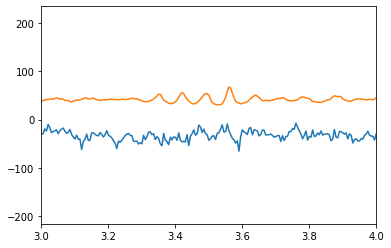

In [71]:
plt.plot(idx_list/200.0, torque_list)
plt.plot(idx_list/200.0, ps)
plt.xlim(3, 4)
plt.show()

In [72]:
def compute_max_corrcoef(x, y, maxlag=100):
    corr_list = []
    lag_list = np.arange(-maxlag, maxlag+1)
    
    Nx = len(x)
    Ny = len(y)
    for lag in np.arange(-maxlag, maxlag+1):
        r = np.corrcoef(x[maxlag:Nx-maxlag], y[maxlag + lag:Nx - maxlag + lag])[0][1]
        
        corr_list.append(r)
    return lag_list, corr_list

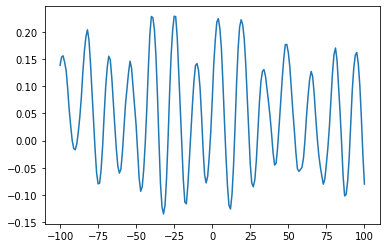

In [78]:
start = 300
end = 900

x = torque_list[start:end]
y = ps[start:end]

lag, corr = compute_max_corrcoef(x, y)
plt.plot(lag, corr)
plt.show()

In [98]:
center_path = '/n/home01/abeane/starbar/plots/pot_center/data'

center_S3 = h5.File(center_path + '/pot_center_phantom-vacuum-Sg20-Rc3.5-lvl3.hdf5', mode='r')


In [101]:
center_S3['PotentialCenter'][:]

array([[199.89385986, 200.00436401, 200.00827026],
       [199.8948388 , 199.98132319, 200.00509825],
       [199.90204685, 199.96091306, 200.00523714],
       ...,
       [200.05865333, 199.80566557, 200.0163316 ],
       [200.05753858, 199.81494749, 200.01358043],
       [200.05614961, 199.81959382, 200.0116857 ]])

In [117]:
torque_path = '/n/home01/abeane/starbar/plots/torques/data'
gas_base = torque_path + '/torques_phantom-vacuum-Sg20-Rc3.5-lvl3/torques_phantom-vacuum-Sg20-Rc3.5-lvl3.'
def read_torque_gas(idx, center, old_center = np.array([200., 200., 200.])):
    fname = gas_base + str(idx) + '.hdf5'
    t = h5.File(fname, mode='r')
    
    torque = t['gas_mass'] * np.cross(t['pos_gas'] + old_center - center, t['acc_gas'])[:,2]
    old_tot = t['total_torques'].attrs['gas'][2]
    t.close()
    return np.array([np.sum(torque), old_tot])
    

In [130]:
idx_list = np.arange(1000, 1200)

out = Parallel(n_jobs=32) (delayed(read_torque_gas)(i, center_S3['PotentialCenter'][i]) for i in tqdm(idx_list))

out = np.array(out)

A Jupyter Widget

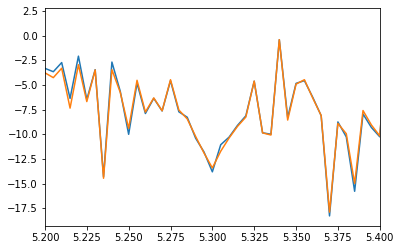

In [133]:
plt.plot(idx_list/200.0, out[:,1])
plt.plot(idx_list/200.0, out[:,0])

plt.xlim(5.2, 5.4)

plt.show()